<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#data" data-toc-modified-id="data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#Unconditional-GAN-for-Fashion-MNIST" data-toc-modified-id="Unconditional-GAN-for-Fashion-MNIST-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Unconditional GAN for Fashion-MNIST</a></span><ul class="toc-item"><li><span><a href="#disect" data-toc-modified-id="disect-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>disect</a></span></li><li><span><a href="#main" data-toc-modified-id="main-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>main</a></span></li><li><span><a href="#plot" data-toc-modified-id="plot-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>plot</a></span></li></ul></li><li><span><a href="#Conditional-GAN-for-Fashion-MNIST" data-toc-modified-id="Conditional-GAN-for-Fashion-MNIST-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conditional GAN for Fashion-MNIST</a></span><ul class="toc-item"><li><span><a href="#main" data-toc-modified-id="main-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>main</a></span></li><li><span><a href="#plot" data-toc-modified-id="plot-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>plot</a></span></li></ul></li></ul></div>

# cDCGAN

Source: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

In [90]:
# example of training an unconditional gan on the fashion mnist dataset
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
import keras 

print('keras.__version__:',keras.__version__)

keras.__version__: 2.2.4


## data

In [1]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


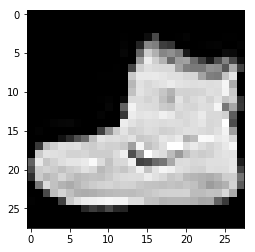

In [6]:
import matplotlib.pyplot as plt
# plot raw pixel data
plt.imshow(trainX[0], cmap='gray')

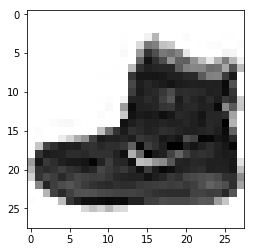

In [7]:
# plot raw pixel data
plt.imshow(trainX[0], cmap='gray_r')

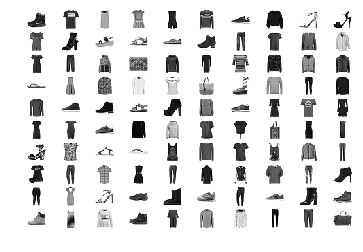

In [8]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
    # define subplot
    pyplot.subplot(10, 10, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

## Unconditional GAN for Fashion-MNIST

### disect

In [1]:

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

Using TensorFlow backend.


In [ ]:
# load fashion mnist images
# def load_real_samples():
# load dataset
(trainX, _), (_, _) = load_data()
# expand to 3d, e.g. add channels
X = expand_dims(trainX, axis=-1)
# convert from ints to floats
X = X.astype('float32')
# scale from [0,255] to [-1,1]
# %time X = (X - 127.5) / 127.5
# dataset = X

# reimplementing scaling as previous code kept getting stuck on my local machine 
n = 127.5
X = np.apply_along_axis(lambda x: (x-n)/n,0,X)
dataset = X

In [30]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
print('discriminator')
discriminator.summary()

# create the generator
generator = define_generator(latent_dim)
print('generator')
generator.summary()

# create the gan
gan_model = define_gan(generator, discriminator)
print('gan')
gan_model.summary()

discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6273   

In [34]:
X_real, y_real = generate_real_samples(dataset, 64)
print(X_real.shape,y_real.shape)
# update discriminator model weights
d_loss1, _ = discriminator.train_on_batch(X_real, y_real)
print(d_loss1)

(64, 28, 28, 1) (64, 1)
0.5779059


/Users/ijung/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [40]:
x_input = generate_latent_points(latent_dim, 10)
print(x_input.shape)
print(x_input[0].shape)

# predict outputs
X = generator.predict(x_input)s
X.shape

(10, 100)
(100,)


(10, 28, 28, 1)

In [61]:
# generate 'fake' examples
X_fake, y_fake = generate_fake_samples(generator, 100, 64)
print(X_fake.shape, y_fake.shape)

# update discriminator model weights
d_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
print(d_loss2)

(64, 28, 28, 1) (64, 1)
0.7010989


/Users/ijung/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [67]:
print(y_real[:10])
print(y_fake[:10])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [60]:
# confirm the weights change 
# before
discriminator.get_weights()[0][0][0][0][:10]

array([ 0.01059567, -0.02451962, -0.01764048,  0.03503487,  0.04263861,
        0.03106245,  0.00265696,  0.06326028, -0.02772803, -0.02624044],
      dtype=float32)

In [62]:
# after 
discriminator.get_weights()[0][0][0][0][:10]

array([ 0.01058434, -0.0244932 , -0.01761705,  0.03504072,  0.04268099,
        0.03107282,  0.00269133,  0.06323232, -0.02775269, -0.02626478],
      dtype=float32)

In [69]:
t = generate_latent_points(latent_dim, 128)
t.shape

(128, 100)

In [72]:
t[0]s

array([-0.612526  , -0.42379035,  1.1818031 , -0.38164974,  0.18947653,
        0.58509033, -0.40914537,  0.32505362,  0.10825274,  0.13549856,
        0.8562396 , -0.72724603, -0.76636565,  0.39648284,  0.67096811,
        0.32304103,  0.2657789 , -0.67238259,  1.30342816, -0.80537871,
       -0.08326365, -0.01278967,  0.72337663,  0.10757208, -2.02059168,
        0.85212533, -1.10243532, -0.05194962,  0.96829996,  1.36776508,
       -1.76971036,  1.0418831 , -2.30949378, -0.67231081,  0.11941592,
       -2.16727077,  0.37157886, -1.07608607, -0.11269064,  0.909922  ,
        0.25189283,  0.17257549, -0.77334011, -0.72362756,  0.55115174,
        0.74078136, -0.51655711,  0.49323186,  0.20629383, -0.21184464,
       -0.05000846,  0.08597169, -0.41507794, -1.74173819,  0.39859519,
       -0.26382542, -1.33242545,  0.35929698, -0.73721449,  0.39907054,
        0.09730262, -1.71610166,  0.22937774,  0.35270355,  0.4503506 ,
        0.16044367, -0.40927225,  0.54471487, -0.22698411,  1.61

In [77]:
# help(discriminator.train_on_batch)

In [74]:
d_loss2, t = discriminator.train_on_batch(X_fake, y_fake)

/Users/ijung/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [81]:
X_gan = generate_latent_points(latent_dim, 128)
# create inverted labels for the fake samples
y_gan = ones((128, 1))
# update the generator via the discriminator's error
g_loss = gan_model.train_on_batch(X_gan, y_gan)
print(g_loss)

0.6780431


In [83]:
# print(y_gan)

In [86]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch) # batch per epoch 
    print('bat_per_epo',bat_per_epo)
    half_batch = int(n_batch / 2)
    print('half_batch',half_batch)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            print(X_real.shape,y_real.shape)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            print(X_fake.shape,y_fake.shape)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

            break 
        break
        
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

print('done')

bat_per_epo 468
half_batch 64
(64, 28, 28, 1) (64, 1)


/Users/ijung/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


(64, 28, 28, 1) (64, 1)
>1, 1/468, d1=0.401, d2=0.772 g=0.634
done


### main

In [5]:
%%time 

# example of training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            
            if j == 467: 
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

done()
slack_done('done with gan')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 468/468, d1=0.712, d2=0.631 g=0.811
>2, 468/468, d1=0.654, d2=0.692 g=0.728
>3, 468/468, d1=0.666, d2=0.627 g=0.818
>4, 468/468, d1=0.671, d2=0.674 g=0.765
>5, 468/468, d1=0.703, d2=0.655 g=0.789
>6, 468/468, d1=0.671, d2=0.685 g=0.734
>7, 468/468, d1=0.688, d2=0.706 g=0.755
>8, 468/468, d1=0.706, d2=0.696 g=0.712
>9, 468/468, d1=0.688, d2=0.686 g=0.723
>10, 468/468, d1=0.689, d2=0.669 g=0.724
>11, 468/468, d1=0.696, d2=0.698 g=0.709
>12, 468/468, d1=0.687, d2=0.702 g=0.712
>13, 468/468, d1=0.686, d2=0.693 g=0.701
>14, 468/468, d1=0.687, d2=0.693 g=0.708
>15, 468/468, d1=0.683, d2=0.704 g=0.714
>16, 468/468, d1=0.711, d2=0.674 g=0.736
>17, 468/468, d1=0.686, d2=0.687 g=0.721
>18, 468/468, d1=0.686, d2=0.703 g=0.713
>19, 468/468, d1=0.706, d2=0.681 g=0.717
>20, 468/468, d1=0.704, d2=0.692 g=0.713
>21, 468/468, d1=0.674, d2=0.710 g=0.708
>22, 468/468, d1=0.695, d2=0.685 g=0.713
>23, 468/468, d1=0.687, d2=0.695 g=0.699
>24, 468/468, d1=0.698, d2=0.693 g=0.713
>25, 468/468, d1=0.700, d

Finished @ 2019-11-10, 07:21:33
sent slack notification
CPU times: user 22min 28s, sys: 2min 57s, total: 25min 25s
Wall time: 20min 57s


### plot

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


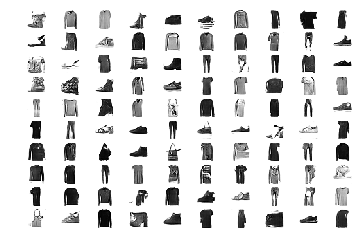

In [7]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.savefig('gan.png')
    pyplot.show()

# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)

## Conditional GAN for Fashion-MNIST

### main

In [11]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load fashion mnist images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]

# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch

            if j == 467: 
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('cgan_generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 468/468, d1=0.647, d2=0.699 g=0.753
>2, 468/468, d1=0.674, d2=0.704 g=0.757
>3, 468/468, d1=0.690, d2=0.624 g=0.843
>4, 468/468, d1=0.611, d2=0.653 g=0.798
>5, 468/468, d1=0.690, d2=0.693 g=0.799
>6, 468/468, d1=0.660, d2=0.652 g=0.784
>7, 468/468, d1=0.651, d2=0.626 g=0.804
>8, 468/468, d1=0.689, d2=0.644 g=0.784
>9, 468/468, d1=0.672, d2=0.676 g=0.808
>10, 468/468, d1=0.680, d2=0.667 g=0.814
>11, 468/468, d1=0.666, d2=0.688 g=0.751
>12, 468/468, d1=0.695, d2=0.667 g=0.822
>13, 468/468, d1=0.706, d2=0.648 g=0.796
>14, 468/468, d1=0.637, d2=0.685 g=0.772
>15, 468/468, d1=0.697, d2=0.676 g=0.756
>16, 468/468, d1=0.676, d2=0.688 g=0.782
>17, 468/468, d1=0.681, d2=0.665 g=0.766
>18, 468/468, d1=0.672, d2=0.665 g=0.814
>19, 468/468, d1=0.681, d2=0.691 g=0.749
>20, 468/468, d1=0.688, d2=0.674 g=0.767
>21, 468/468, d1=0.667, d2=0.645 g=0.760
>22, 468/468, d1=0.656, d2=0.657 g=0.786
>23, 468/468, d1=0.706, d2=0.671 g=0.777
>24, 468/468, d1=0.747, d2=0.672 g=0.751
>25, 468/468, d1=0.713, d

### plot

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


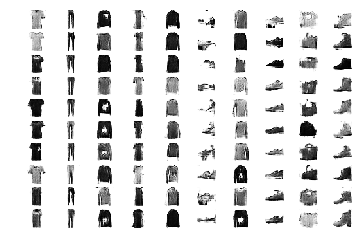

In [9]:
# img after 10 epochs

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


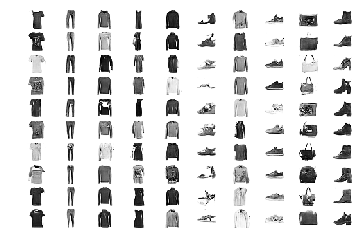

In [13]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.savefig('cgan.png')
    pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)